# Make buoy data file

Standardize buoy data and put it together in a Pandas dataframe.

Most of the data is read from the TABS website using the [`tabs` package from github](https://github.com/kthyng/tabs.git). 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!

from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from datetime import datetime, timedelta
import datedelta
import gsw
import tabs
import shapely
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

In [2]:
b = '../data/'
baseb = b + 'bathy/'
basesf = b + 'shapefiles/'
based = b + 'stations/'

In [3]:
run buoy_info.py

In [4]:
savename = based + 'data08to08-15min.csv'
dstart = '2017-08-01'; dend = '2018-08-01'
tz = 'UTC'  # 'US/Central'

In [5]:
if not os.path.exists(savename):
        
    ## Stream gauges. Data brought in from USGS.
    stations = ['08077600', '08074500', '08067252']  
    df = tabs.read(stations, dstart, dend, resample=('15T',0,'instant'))
              
    ## Gauge height. From USGS.
    station = '08072000'
    df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'instant'), var='height'))

    ## TWDB data
    names = ['FISH', 'MIDG', 'OLDR', 'TRIN', 'BOLI']
    for name  in names:
        df = df.join(tabs.read(name, dstart, dend, resample=('15T',0,'instant')))

    ## TABS data
    df = df.join(tabs.read('B', dstart, dend, resample=('15T',0,'instant')))
            
    ## NOS/NDBC buoys
    stations = ['8771486','8770613','8771013','8771341','8771450','8770777']
    for station in stations:
        df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'instant'), datum='MHW'))
                 
    ## Entrance channel velocity. From NOAA PORTS.
    df = df.join(tabs.read('g06010', dstart, dend, resample=('15T',0,'mean')))
                
    df.tz_localize(None).to_csv(savename)  # save as a csv file
else:
    df = pd.read_csv(savename, parse_dates=True, index_col=0)

In [6]:
# These definitions are used for the plot below

land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 200, 'alpha': 1, 'linewidths': 2}, 
         'Gage height [m]': {'marker': 'o', 's': 200, 'alpha': 1}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':200, 'alpha': 1},
         'Flow rate [m^3/s]': {'marker': '>', 's': 200, 'alpha': 1}}

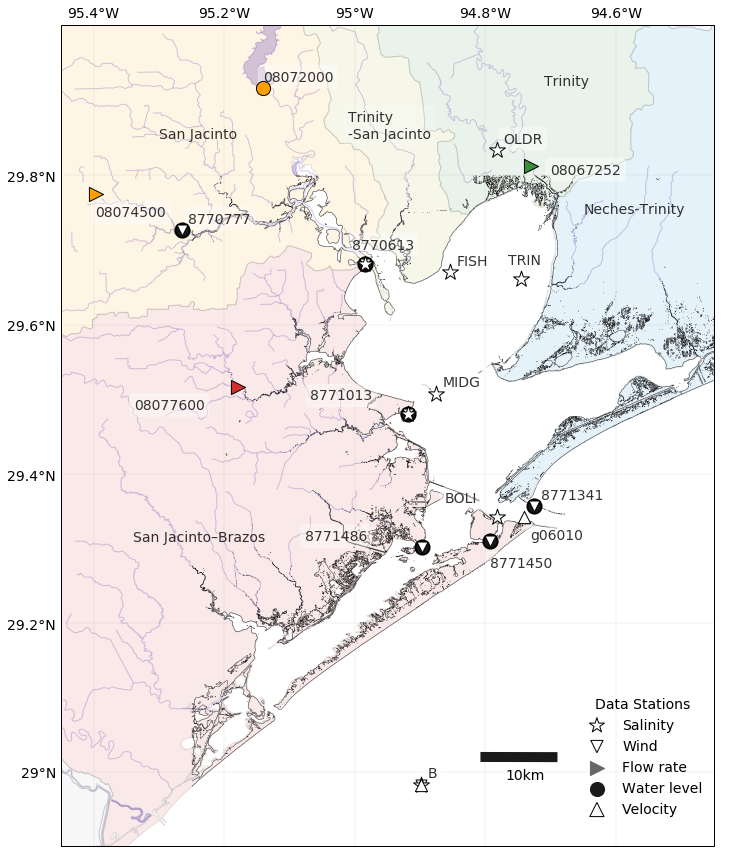

In [7]:
# These bathymetry files are created in notebook "Process bathymetry.ipynb"
d = np.load(baseb + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(baseb + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

extent = [-95.45, -94.45, 28.9, 30.0]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry, but only near bay
# mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
# cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
# cb.set_label('Depth [m]')

# # add background land
# ax.add_feature(land_10m)

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline


# Add river basins to plot
reader = cartopy.io.shapereader.Reader(basesf + 'Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.4)
        
## add buoys ##
for buoy in ['08077600', '08074500', '08067252', '08072000', 'FISH', 'MIDG', 'OLDR', 'TRIN', 'BOLI', 
             'B', '8771486','8770613','8771013','8771341','8771450','8770777', 'g06010']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.2', bbox=props)
    for var in plots.keys():
        if var in buoys[buoy]['vars']:
            kwargs = plots[var]
            # use buoy color in some cases
            if not 'color' in kwargs:
                color = buoys[buoy]['color']
                ax.scatter(*buoys[buoy]['ll'], **kwargs, facecolors=color, transform=pc, label=var, edgecolors='k', zorder=5)
            else:
                ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)

# Add labels
ax.text(-95.3, 29.85, 'San Jacinto', transform=pc, alpha=0.8)
ax.text(-95.01, 29.85, 'Trinity\n-San Jacinto', transform=pc, alpha=0.8, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.34, 29.31, 'San Jacinto–Brazos', transform=pc, alpha=0.8)
ax.text(-94.71, 29.92, 'Trinity', transform=pc, alpha=0.8)
ax.text(-94.65, 29.75, 'Neches-Trinity', transform=pc, alpha=0.8);

# Distance key
llon, llat = -94.8, 29.02
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.03, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.72, 0.03, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Water level')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('../figures/map_includeddata.png', bbox_inches='tight', dpi=300)
fig.savefig('../figures/map_includeddata_lowres.png', bbox_inches='tight')